In [2]:
!pip install -q wordcloud
!pip install -q nltk

In [3]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

import re

import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Step 1: Retrieving the data

In [11]:
# File paths to train and test data
REVIEWS_TRAIN_DIR = 'amazon_review_polarity_csv/train.csv'
REVIEWS_TEST_DIR = 'amazon_review_polarity_csv/test.csv'

# Load train and test data 
data_train = pd.read_csv(REVIEWS_TRAIN_DIR, names=["label", "title", "review"])
data_test = pd.read_csv(REVIEWS_TEST_DIR, names=["label", "title", "review"])

print("Amazon reviews: train = {:,}, test = {:,}".format(len(data_train), len(data_test)))

Amazon reviews: train = 3,600,000, test = 400,000


## Step 2: Exploring the data

In [3]:
# Train data overview
data_train.head()

,label,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [4]:
data_train.review[0]

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

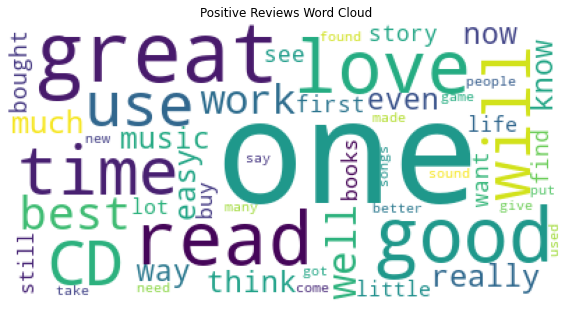

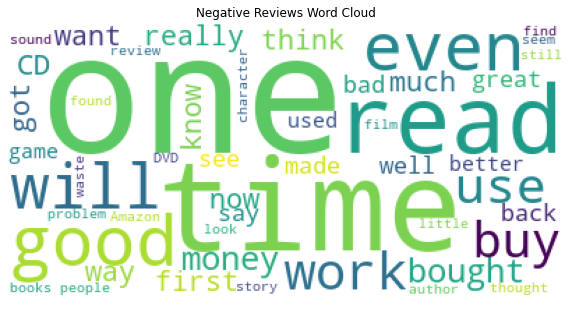

In [5]:
# Sample and combine 50,000 positive and negative revews, respectively
n_samples = 50000
pos_reviews = " ".join([
    review for review in data_train[data_train.label == 2].sample(n_samples).review])
neg_reviews = " ".join([
    review for review in data_train[data_train.label == 1].sample(n_samples).review])

# Create positive word cloud object
wc = WordCloud(background_color='white', 
               max_words=50,
               # update stopwords to include common words in reviews
               stopwords=STOPWORDS.update([
                   'book', 'movie', 'song', 'product', 'CD'
                   'time', 'make', 'album', 'thing']))

# Generate and plot pos wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(pos_reviews))
plt.axis('off')
plt.title('Positive Reviews Word Cloud', fontsize=12)
plt.show();

# Generate and plot neg wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(neg_reviews))
plt.axis('off')
plt.title('Negative Reviews Word Cloud', fontsize=12)
plt.show();

In [12]:
# Calcuate number of positive and negative reviews in train and test data
n_neg_train, n_pos_train = data_train.label.value_counts()
n_neg_test, n_pos_test = data_test.label.value_counts()
print("Amazon reviews: train = {:,} neg / {:,} pos, test = {:,} neg / {:,} pos".format(
    n_neg_train, n_pos_train, n_neg_test, n_pos_test))

Amazon reviews: train = 1,800,000 neg / 1,800,000 pos, test = 200,000 neg / 200,000 pos


## Step 2: Preparing the data

In [13]:
# Split data into features and labels
features_train, labels_train = data_train.review, data_train.label
features_test, labels_test = data_test.review, data_test.label

# Shuffle data (common practice)
features_train, labels_train = shuffle(features_train, labels_train, random_state=0)
features_test, labels_test = shuffle(features_test, labels_test, random_state=0)

## Step 3: Processing the data

### Step 3.1: Normalizing feature text

In [32]:
# Tokenize anything that is not a number and not a symbol and not a punctuation
word_tokenizer = RegexpTokenizer(r'[^\d\W_]+')

# Create a lemmatizer object
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Create a set of stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add more extra stop words
stop_words |= {'book', 'movie', 'song', 'product', 'CD', 'time', 'make', 'album', 'thing'}

def preprocess(text):
    """Normalize text."""
    # Tokenization and lemmatization
    lemmetized_text = [
        lemmatizer.lemmatize(lemmatizer.lemmatize(word.lower(),'n'),'v') \
        for word in word_tokenizer.tokenize(text)
        ]
    # Remove stop words and words whose length is less than 3
    return ' '.join([
        word for word in lemmetized_text if len(word) > 2
        ])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HONGW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HONGW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Skip this cell and go to the third cell from here to load the features, it takes an hour to run
features_train_preprocessed = features_train.apply(preprocess)
features_test_preprocessed = features_test.apply(preprocess)

In [34]:
# Save processed train features to .csv file
features_train_preprocessed.to_csv('amazon_review_polarity_csv/X_train.csv', 
                                   header=False, 
                                   index=False)

In [35]:
# Save processed test features to .csv file
features_test_preprocessed.to_csv('amazon_review_polarity_csv/X_test.csv', 
                                  header=False,
                                  index=False)

In [4]:
# Load the clean train and test features
features_train_preprocessed = pd.read_csv('amazon_review_polarity_csv/X_train.csv', 
                                          names=['review'],
                                          dtype=str)
features_test_preprocessed = pd.read_csv('amazon_review_polarity_csv/X_test.csv', 
                                         names=['review'],
                                         dtype=str)

In [5]:
# Create tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=5000, lowercase=False)

In [6]:
# Vectorize train data
X_train = vectorizer.fit_transform(
    features_train_preprocessed['review'].apply(lambda x: np.str_(x)))

In [7]:
# Vectorize test data
X_test = vectorizer.transform(
    features_test_preprocessed['review'].apply(lambda x: np.str_(x)))

### Step 3.2: Converting labels

In [15]:
# Maps negative to 0 and positive to 1
y_train, y_test = labels_train - 1, labels_test - 1

In [19]:
# Load the clean train and test labels
y_train = pd.read_csv('amazon_review_polarity_csv/y_train.csv', names=['label'])
y_test = pd.read_csv('amazon_review_polarity_csv/y_test.csv', names=['label'])

## Step 4: Modeling

### Step 4.1: Logistic

In [20]:
lr = LogisticRegression(random_state=0)

In [21]:
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [22]:
y_pred = lr.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.8724725